In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand
import pickle as pk
from tqdm import tqdm
import os

In [2]:
def metropolis(config,T): # config 를 온도 T에 맞춤 : external field = 0 
    N = len(config)
    for i in range(N):
        for j in range(N):
            dE=2.*config[i,j]*(config[(i-1)%N,j%N]+config[(i+1)%N,j%N]+config[i%N,(j+1)%N]+config[i%N,(j-1)%N])
            if dE<0.:
                config[i,j]=-config[i,j]
            elif rand()<np.exp(-dE/T):
                config[i,j]=-config[i,j]
    return config

def energy(config):# 에너지 계산 : H = h*Si + K*Si*Sj.
    N = len(config)
    E=0.
    for i in range(N):
        for j in range(N):
            E-=config[i,j]*(config[(i-1)%N,j%N]+config[(i+1)%N,j%N]+config[i%N,(j+1)%N]+config[i%N,(j-1)%N])/(N**2)
    return E/2.
    

def auto_correlation(mag,time_inter,sample_size):
    
    ## input 
    ## config = (Spin array , Samples) 
    ## time interval = (int)
    
    autocorrelation = 0.
    C_ave = 0.
    
    for step in range(sample_size - time_inter):
    
        C_ave += mag[step]/(sample_size - time_inter) ### Sum[(X) / (N-k)]
    
    for step in range(sample_size - time_inter):
    
        C_T = mag[step+time_inter]
    
        C_0 = mag[step]
        
        autocorrelation += (C_0 - C_ave) * (C_T - C_ave) / (sample_size - time_inter)
        
    return autocorrelation

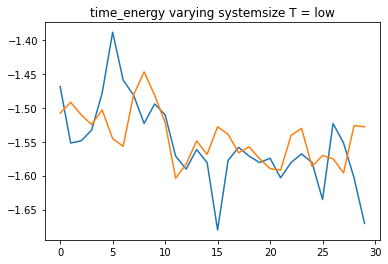

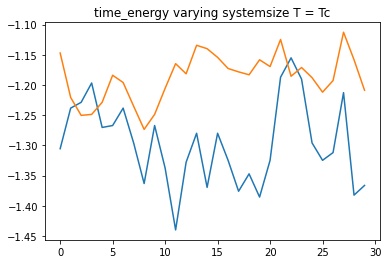

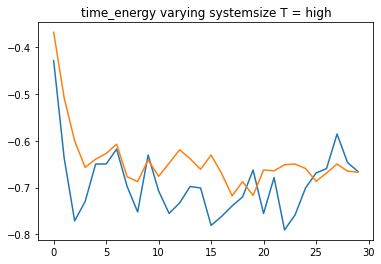

In [19]:
# check steady state##

N_arr = [5,10]
ens = 50
T=np.arange(3.5,2.1,-0.1)


eq_T=30
E_arr = np.zeros((len(T),eq_T,ens,len(N_arr)))


for n,N in enumerate(N_arr):
    for en in range(ens):
        config = np.random.choice((-1,1),size = (N,N))
        
        for i,t in enumerate(T):
            for j in range(eq_T):# equali- time
                config = metropolis(config,t)
                E_arr[i,j,en,n] = energy(config)
                
                
ave_E_arr = np.average(E_arr,axis = 2)                
plt.title('time_energy varying systemsize T = low')
plt.plot(range(eq_T),ave_E_arr[-1,:,:])
plt.savefig('save/check steady state_T_low.svg')
plt.show()

plt.title('time_energy varying systemsize T = Tc')
plt.plot(range(eq_T),ave_E_arr[10,:,:])
plt.savefig('save/check steady state_T_Tc.svg')
plt.show()

plt.title('time_energy varying systemsize T = high')
plt.plot(range(eq_T),ave_E_arr[0,:,:])
plt.savefig('save/check steady state_T_high.svg')
plt.show()

## 결론 T =Tc 근처에서 equ state 늦게 도착함.
## T = high 이면, fluctuation 매우 심함. 

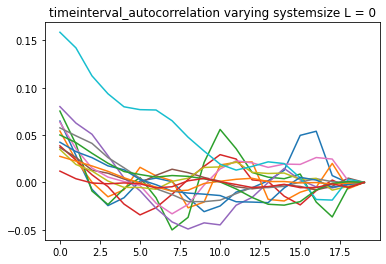

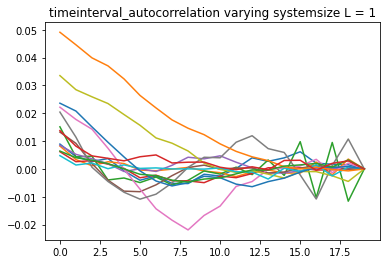

In [20]:
## calculate auttocorrelation ##

N_arr = [5,10]
ens = 5
T=np.arange(3.5,2.1,-0.1)
eq_T=500
save_T=20
M_arr = np.zeros((len(T),save_T,ens,len(N_arr)))


for n,N in enumerate(N_arr):
    for en in range(ens):
        config = np.random.choice((-1,1),size = (N,N))
        
        for i,t in enumerate(T):
            for _ in range(eq_T):# equali- time
                config = metropolis(config,t)

            for j in range(save_T):# clac- time
                config  = metropolis(config,t)
                M_arr[i,j,en,n] = np.average(config)
                

ave_M_arr = np.average(M_arr,axis = 2) 
autocorrelation_arr = np.zeros((save_T, len(T)))

for N_idx, N in enumerate(range(len(N_arr))):
    for i,t in enumerate(T):
        m = ave_M_arr[i,:,N]
        for j in range(save_T):
            
            autocorrelation_arr[j,i] = auto_correlation(m,j,save_T)
        
    plt.title('timeinterval_autocorrelation varying systemsize L = %d'%N)
    plt.plot(range(save_T),autocorrelation_arr)
    plt.savefig('save/autocorrelation_L%d.svg'%N)
    plt.show()


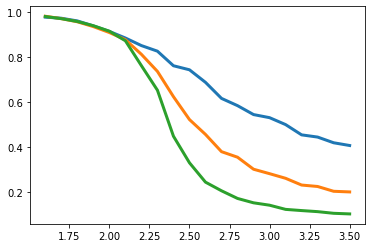

In [25]:
# save M,M**2,M**4 

N_arr = [5,10,20]
T=np.arange(3.5,1.5,-0.1)

eq_T=500
save_T=500

ens = 5

M_arr = np.zeros((len(T),save_T,ens))
M2_arr = np.zeros((len(T),save_T,ens))
M4_arr = np.zeros((len(T),save_T,ens))

for n,N in enumerate(N_arr):
    for en in range(ens):
        config = np.random.choice((-1,1),size = (N,N))
        
        for i,t in enumerate(T):
            for _ in range(eq_T):# equali- time
                config = metropolis(config,t)

            for j in range(save_T):# clac- time
                config  = metropolis(config,t)
                
                M_arr[i,j,en] = abs(np.average(config))
                M2_arr[i,j,en] = abs(np.average(config))**2
                M4_arr[i,j,en] = abs(np.average(config))**4
                
    M = np.average(M_arr , axis = (1,2))
    M2 = np.average(M2_arr , axis = (1,2))
    M4 = np.average(M4_arr , axis = (1,2))
    np.savez('save/2d_Ising_L%d'%N, M =  M, M2 = M2, M4 = M4)
    
    plt.plot(T,M,lw=3)